In [423]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
from random import randint

## Generate rotated card

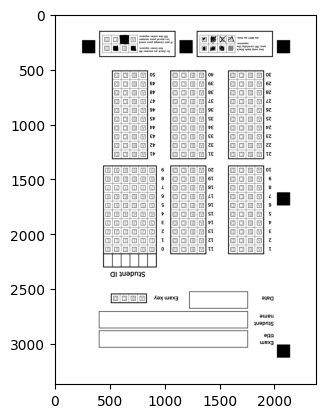

In [431]:
img = cv2.imread("svgtest.png")
angle = randint(-90, 90)
angle = 180
def rotate_image(image, angle):
    h, w = img.shape[:2]
    cx, cy = (w // 2, h // 2)

    # get rotation matrix (explained in section below)
    M = cv2.getRotationMatrix2D((cx, cy), angle, 1.0)

    # get cos and sin value from the rotation matrix
    cos, sin = abs(M[0, 0]), abs(M[0, 1])

    # calculate new width and height after rotation (explained in section below)
    newW = int((h * sin) + (w * cos))
    newH = int((h * cos) + (w * sin))

    # calculate new rotation center
    M[0, 2] += (newW / 2) - cx
    M[1, 2] += (newH / 2) - cy

    # use modified rotation center and rotation matrix in the warpAffine method
    return cv2.warpAffine(image, M, (newW, newH), borderMode=cv2.BORDER_CONSTANT,
                            borderValue=(255,255,255)) 
                

new_image = rotate_image(img, angle)
plt.imshow(new_image);

In [425]:
gray_image = cv2.cvtColor(new_image, cv2.COLOR_RGB2GRAY)
mask = cv2.inRange(gray_image, 0, 150)

# apply morphology
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9,9))
clean = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15,15))
clean = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

# get external contours
contours = cv2.findContours(clean, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = contours[0] if len(contours) == 2 else contours[1]

squares = []
for c in contours:
    # get rotated rectangle from contour
    rot_rect = cv2.minAreaRect(c)
    if abs(rot_rect[1][0] - rot_rect[1][1]) < min(rot_rect[1]) / 50:
        squares.append(rot_rect)

result1 = np.full_like(gray_image, fill_value=255)
for rect in squares:
    box = cv2.boxPoints(rect) # cv2.boxPoints(rect) for OpenCV 3.x
    box = np.int0(box)
    cv2.drawContours(result1, [box], 0, 0, -1)

# plt.imshow(result1, cmap='gray', vmin=0, vmax=255)
print(len(squares))

5


In [426]:
def calculate_delta(first_pos, second_pos):
        return abs(first_pos[0] - second_pos[0]), abs(first_pos[1] - second_pos[1])
        
def set_numeric_values_squares(contours):
    def is_similar(first_delta, second_delta):
        return abs(first_delta[0] - second_delta[0]) <= min(first_delta[0], second_delta[0]) / 100 and \
               abs(first_delta[1] - second_delta[1]) <= min(first_delta[1], second_delta[1]) / 100

    # Top       left: 4,                right: -
    # Middle    left: 3
    # Bottom    left: 0,    middle 1,   right: 2
    # Page width = distance between 0 and 2
    # Page height = distance between 0 and 4
    
    # Find three squares lines 
    # (should be two, first vertical on left side, second horizontal on bottom)
    points = []
    print(contours)
    for first_idx in range(len(contours)):
        first_point = contours[first_idx]
        for second_idx in range(first_idx + 1, len(contours)):
            second_point = contours[second_idx]
            for third_idx in range(second_idx + 1, len(contours)):
                third_point = contours[third_idx]
                fs_delta = calculate_delta(first_point[0], second_point[0])
                ft_delta = calculate_delta(first_point[0], third_point[0])
                st_delta = calculate_delta(second_point[0], third_point[0])
                if is_similar(fs_delta, st_delta):
                    points.append([first_point, second_point, third_point])
                elif is_similar(fs_delta, ft_delta):
                    points.append([second_point, first_point, third_point])  
                elif is_similar(st_delta, ft_delta):
                    points.append([first_point, third_point, second_point])
    
    assert len(points) == 2, "Didn't detect two lines of squares, can't rotate page"


    # Reorder points based on commonly shared sqare (0 index square)
    first_line = points[0]
    second_line = points[1]

    if first_line[0] == second_line[0]:
        pass
    elif first_line[2] == second_line[2]:
        first_line = first_line[::-1] 
        second_line = second_line[::-1] 
    elif first_line[0] == second_line[2]:
        second_line = second_line[::-1]
    elif first_line[2] == second_line[0]:
        first_line = first_line[::-1]
    
    # Calculate length of lines based on length of lines
    fl_x, fl_y = calculate_delta(first_line[0][0], first_line[2][0])
    sl_x, sl_y = calculate_delta(second_line[0][0], second_line[2][0])

    fl_dist = (fl_x ** 2 + fl_y ** 2) ** (1/2)
    sl_dist = (sl_x ** 2 + sl_x ** 2) ** (1/2)

    # Assign lines to proper values
    if fl_dist < sl_dist:
        horizontal_line = first_line
        vertical_line = second_line
    else:
        vertical_line = second_line
        horizontal_line = first_line

    # Assign indexes to proper squares
    numered_points = dict(enumerate([*horizontal_line, *vertical_line[1:]]))
    return numered_points


numered_squares = set_numeric_values_squares(squares)
print(numered_squares, angle)

[((2074.5, 3070.0), (120.0, 119.0), 90.0), ((1189.5, 3070.0), (120.0, 119.0), 90.0), ((304.5, 3070.0), (120.0, 119.0), 90.0), ((304.5, 1685.0), (120.0, 119.0), 90.0), ((304.5, 300.0), (120.0, 119.0), 90.0)]
{0: ((304.5, 3070.0), (120.0, 119.0), 90.0), 1: ((1189.5, 3070.0), (120.0, 119.0), 90.0), 2: ((2074.5, 3070.0), (120.0, 119.0), 90.0), 3: ((304.5, 1685.0), (120.0, 119.0), 90.0), 4: ((304.5, 300.0), (120.0, 119.0), 90.0)} 0


In [427]:
def find_middle_of_page(numered_points):
    zero_pos = np.array(numered_points[0][0])
    first_pos = np.array(numered_points[1][0])
    third_pos = np.array(numered_points[3][0])
    zero_to_one_distance = first_pos - zero_pos
    zero_to_three_distance = third_pos - zero_pos
    middle_from_one = first_pos + zero_to_three_distance
    middle_from_three = third_pos + zero_to_one_distance
    return (middle_from_one + middle_from_three) / 2
    
def find_angle_of_page(numered_squares):
    zero_square = np.array(numered_squares[0][0])
    first_square = np.array(numered_squares[1][0])
    opposite_to_angle = zero_square[0] - first_square[0]
    hypotenuse = sum((zero_square - first_square) ** 2) ** (1/2)
    print(opposite_to_angle, hypotenuse)
    return math.asin(opposite_to_angle/hypotenuse) * 180 / math.pi
    

middle_pos = find_middle_of_page(numered_squares)
new_angle = find_angle_of_page(numered_squares)

# TODO Manage how to calculate angle
new_angle = int(new_angle + 0.5 * (new_angle / abs(new_angle)))
if new_angle > 0:
    if new_angle < 45:
        new_angle += 90
    else:
        new_angle *= -1
elif new_angle < 0:
    new_angle += 90
print(new_angle, angle)
print(middle_pos)

-885.0 885.0
0 0
[1189.5 1685. ]


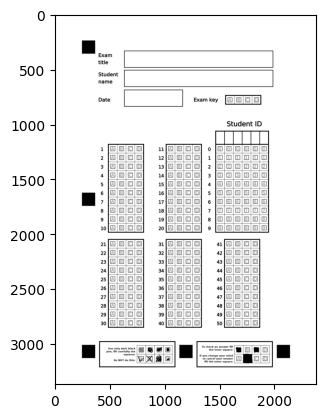

In [428]:
result = rotate_image(new_image, new_angle)

plt.imshow(result);